In [4]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2025-09-28 12:20:25.116541


In [5]:
#####################################################################
# In order to use GPU acceleration, you must change runtime type.
# See the menu bar above.
# "Runtime" -> "Change runtime type"  -> "Hardware accelerator"
# Change 'None' to 'GPU', then run the code below.
#####################################################################

import sys
import platform
import torch

print("Python version")
print(sys.version_info)

print("\nOS information")
print(platform.platform())

print("\nIs GPU available?")
print(torch.cuda.is_available())

# print("\nCPU information")
# !cat /proc/cpuinfo

# print("\nMemory information")
# !cat /proc/meminfo

print("\nGPU information")
!nvidia-smi

Python version
sys.version_info(major=3, minor=12, micro=11, releaselevel='final', serial=0)

OS information
Linux-6.6.97+-x86_64-with-glibc2.35

Is GPU available?
True

GPU information
Sun Sep 28 12:20:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              9W /   70W |   

## 1. VGGNet with PyTorch

### Implementing VGGNet

1. **Dataset**
 - Images from the first three categories in CIFAR-10. (Due to the computational constraints.)  <br>
     Three categories : plane, car, bird  /  The number of training images : 15,000   /  The number of test images : 3,000
 - Augmented with flipping and random cropping.

 2. **Network architecture**
 - Type-D configuration in the paper (+ 3-way classifier after convolutional layers).
 - ReLU activation.
 - No dropout for simplicity.
 - We will apply **batch-normalization** after every convolution which is not used in the paper (otherwise, hard to optimize).

 <table><tr>
 <td> <img src="https://docs.google.com/uc?export=download&id=1WoLTNYR11nbIE7ovpaum2DN_u71zow6r" alt="no_image" style="width: 550px;"/> </td>
 </tr></table>

 <font size="0.5"> Figure from <br>
 [1] https://www.quora.com/What-is-the-VGG-neural-network </font>

3. **Loss function**
 - Cross-entropy loss between outputs & ground-truths. <br>
     Note that `nn.CrossEntroyLoss` takes logits before softmax as network outputs and scalar index (not one-hot vector) as ground-truths.<br>
     See https://pytorch.org/docs/stable/nn.html#crossentropyloss for details.

 4. **Training**
 - Default weight initialization for simplicity.
 - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
 - 20 epochs without learning rate scheduling.

 5. **Evaluation metric**
 - Classification accuracy (i.e., the percentage of correct predictions).

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision
import time
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [18]:
print('STEP 1: LOADING DATASET')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = dsets.CIFAR10(root='./data/CIFAR10/',
                            train=True,
                            transform=transform_train,
                            download=True)

test_dataset = dsets.CIFAR10(root='./data/CIFAR10/',
                           train=False,
                           transform=transform_test)

STEP 1: LOADING DATASET


In [19]:
# reducing the dataset
reduced_train_dataset = []
for images, labels in train_dataset:
    if labels < 3:
        reduced_train_dataset.append((images, labels))

reduced_test_dataset = []
for images, labels in test_dataset:
    if labels < 3:
        reduced_test_dataset.append((images, labels))

In [20]:
print("The number of training images : ", len(reduced_train_dataset))
print("The number of test images : ", len(reduced_test_dataset))

The number of training images :  15000
The number of test images :  3000


In [21]:
print('STEP 2: MAKING DATASET ITERABLE')

train_loader = torch.utils.data.DataLoader(dataset=reduced_train_dataset,
                                           batch_size=128,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=reduced_test_dataset,
                                          batch_size=100,
                                          shuffle=False)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

STEP 2: MAKING DATASET ITERABLE


### Visualize a few images

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [23]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

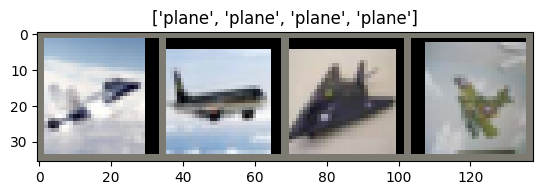

In [24]:
train_loader_sample = torch.utils.data.DataLoader(dataset=reduced_train_dataset,
                                           batch_size=4,
                                           shuffle=True)

# Get a batch of training data
inputs, classes = next(iter(train_loader_sample))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 1.1 VGG 16

In [ ]:
print('STEP 3: CREATE MODEL CLASS (VGG16)')

## BatchNorm2d(in_channel)

cfg = [64, 64, 'MP', 128, 128, 'MP', 256, 256, 256, 'MP', 512, 512, 512, 'MP', 512, 512, 512, 'MP']

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.VGG16 = self._make_layers(cfg)
        self.classifier = nn.Linear(512, 3)

    def forward(self, x):
        out = self.VGG16(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)

        return out

    def _make_layers(self,cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'MP':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1, bias=False),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x

        return nn.Sequential(*layers)

STEP 3: CREATE MODEL CLASS (VGG16)


In [26]:
print('STEP 4: INSTANTIATE MODEL CLASS')

model = VGG()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)
#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  14720451


VGG(
  (VGG16): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [27]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion = nn.CrossEntropyLoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum, weight_decay = weight_decay)

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


### 1.2 Train the VGG 16 model and print test accuracy for every epochs

In [ ]:
print('STEP 7: TRAIN THE MODEL')
num_epochs = 20

torch.backends.cudnn.benchmark = True  # 고정 해상도에 유리

for epoch in range(num_epochs):
    start_time = time.time()

    # --- Train ---
    model.train()
    running_loss = 0.0
    num_samples = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        bs = labels.size(0)
        running_loss += loss.item() * bs
        num_samples += bs

    avg_loss = running_loss / max(1, num_samples)

    # --- Eval ---
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    accuracy = 100.0 * correct / total
    elapsed_time = time.time() - start_time
    print(f'Epochs: {epoch}. Loss: {avg_loss}. Accuracy: {accuracy}. Elapsed time: {elapsed_time} sec')

STEP 7: TRAIN THE MODEL
Epochs: 0. Loss: 0.6472929278373718. Accuracy: 83.9. Elapsed time: 8.449090480804443 sec
Epochs: 1. Loss: 0.3856262704928716. Accuracy: 86.93333333333334. Elapsed time: 5.9889140129089355 sec
Epochs: 2. Loss: 0.31075008492469786. Accuracy: 86.96666666666667. Elapsed time: 6.007593631744385 sec
Epochs: 3. Loss: 0.24122336463928223. Accuracy: 89.9. Elapsed time: 6.042424917221069 sec
Epochs: 4. Loss: 0.1914971242348353. Accuracy: 90.33333333333333. Elapsed time: 6.07253623008728 sec
Epochs: 5. Loss: 0.1652734676361084. Accuracy: 90.46666666666667. Elapsed time: 6.102776288986206 sec
Epochs: 6. Loss: 0.1300894491672516. Accuracy: 90.9. Elapsed time: 6.146520376205444 sec
Epochs: 7. Loss: 0.09885213945706685. Accuracy: 90.9. Elapsed time: 6.175989627838135 sec
Epochs: 8. Loss: 0.08543414944807688. Accuracy: 92.96666666666667. Elapsed time: 6.2274489402771 sec
Epochs: 9. Loss: 0.06569290569325288. Accuracy: 90.1. Elapsed time: 6.257114887237549 sec
Epochs: 10. Loss: 

## 2. ResNet with PyTorch

### Implementing ResNet

 1. **Dataset**
 - The same dataset used for VGGNet

 2. **Network architecture**
 - 50-layer ResNet with **bottleneck blocks**. <br>
     Note. The initial convolution layer (i.e., conv1) is different from the one in the paper &<br>
     the initial max-pooling layer is removed (because the size of CIFAR-10 images is too small).
 - ReLU activation.
 - Strided convolution for down-sampling instead of max-pooling layer. <br>
     Note. Once down-sampled, a $1\times1$ convolution/stride 2 is applied to residual for expanding the channel of the residual.
 - No dropout for simplicity.
 - Batch-normalization after every convolution.


 <table><tr>
 <td> <img src="https://docs.google.com/uc?export=download&id=1UbSh2w83Tb0VVgXxyly_VAUPwE7UsdAE" alt="no_image" style="width: 500px;"/> </td>
 </tr></table>

 <font size="0.5"> Figures from <br>
 [1] https://www.codeproject.com/Articles/1248963/Deep-Learning-using-Python-plus-Keras-Chapter-Re  <br>
 [2] Rezende et al., *Signal Processing: Image Communication*, 2018. </font>

3. **Loss function**
- Cross-entropy loss between outputs & ground-truths. <br>

4. **Training**
 - Default weight initialization for simplicity.
 - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
- 15 epochs without learning rate scheduling.

5. **Evaluation metric**
 - Classification accuracy (i.e., the percentage of correct predictions).

### 2.1 ResNet50 and train it with the CIFAR 10 dataset

In [ ]:
print('STEP 3: CREATE MODEL CLASS (ResNet-50)')

cfg = [3,4,6,3]

class ResNet_block(nn.Module):
    def __init__(self, in_c, intra_c, out_c, down_sample = False):
        super(ResNet_block, self).__init__()

        self.down_sample = down_sample
        self.expand = (in_c != out_c)
        stride = 2 if self.down_sample else 1

        # Bottleneck Block의 3개 Convolution Layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_c, intra_c, kernel_size=1, bias=False),
            nn.BatchNorm2d(intra_c),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(intra_c, intra_c, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(intra_c),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(intra_c, out_c, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_c)
        )

        # 마지막 BatchNorm의 gamma(weight)를 0으로 초기화 (Identity Mapping)
        nn.init.constant_(self.conv3[1].weight, 0)

        # Shortcut 연결의 차원을 맞춰주기 위한 1x1 Conv 레이어
        if self.down_sample or self.expand:
            self.convert_id = nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_c)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        if self.down_sample or self.expand:
            identity = self.convert_id(x)
        out = F.relu(out + identity)
        return out

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.init_block = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # ResNet-50 구조에 맞게 각 스테이지 생성
        self.ResBlock1 = self._make_layers(64, 64, 256, cfg[0], False)
        self.ResBlock2 = self._make_layers(256, 128, 512, cfg[1], True)
        self.ResBlock3 = self._make_layers(512, 256, 1024, cfg[2], True)
        self.ResBlock4 = self._make_layers(1024, 512, 2048, cfg[3], True)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(2048, 3) # 3개 클래스

    def forward(self, x):
        out = self.init_block(x)
        out = self.ResBlock1(out)
        out = self.ResBlock2(out)
        out = self.ResBlock3(out)
        out = self.ResBlock4(out)
        out = self.avgpool(out)
        out= out.view(out.size(0), -1)
        out = self.classifier(out)

        return out

    def _make_layers(self, in_c, intra_c, out_c, num_block, down_sample):
        layers = []
        # first block
        layers.append(ResNet_block(in_c = in_c, intra_c = intra_c, out_c = out_c, down_sample = down_sample))
        # intermediate blocks
        for _ in range(num_block - 1):
            layers.append(ResNet_block(in_c = out_c, intra_c = intra_c, out_c = out_c, down_sample = False))

        return nn.Sequential(*layers)


print('STEP 4: INSTANTIATE MODEL CLASS')

model = ResNet().to(device)
num_total_params = sum(p.numel() for p in model.parameters())


STEP 3: CREATE MODEL CLASS (ResNet-50)
STEP 4: INSTANTIATE MODEL CLASS


### 2.2 Print test accuracy for every epochs.

In [ ]:
print('STEP 5: INSTANTIATE LOSS CLASS')
criterion = nn.CrossEntropyLoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')
learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

print('STEP 7: TRAIN THE MODEL')
num_epochs = 15

for epoch in range(num_epochs):
    start_time = time.time()

    # Training
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Testing
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    end_time = time.time()
    elapsed_time = end_time - start_time
    avg_loss = running_loss / len(train_loader)

    print(f'Epochs: {epoch}. Loss: {avg_loss}. Accuracy: {accuracy}. Elapsed time: {elapsed_time} sec')



STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS
STEP 7: TRAIN THE MODEL
Epochs: 0. Loss: 0.7979839595697694. Accuracy: 65.06666666666666. Elapsed time: 55.29575204849243 sec
Epochs: 1. Loss: 0.7301469697790631. Accuracy: 62.86666666666667. Elapsed time: 51.211266040802 sec
Epochs: 2. Loss: 0.6463428172519652. Accuracy: 70.93333333333334. Elapsed time: 51.48332238197327 sec
Epochs: 3. Loss: 0.5726530736280699. Accuracy: 75.83333333333333. Elapsed time: 51.33338403701782 sec
Epochs: 4. Loss: 0.5256079084287255. Accuracy: 76.93333333333334. Elapsed time: 51.202558755874634 sec
Epochs: 5. Loss: 0.47675878087342793. Accuracy: 76.73333333333333. Elapsed time: 51.18898606300354 sec
Epochs: 6. Loss: 0.44700888051825055. Accuracy: 79.03333333333333. Elapsed time: 51.22559952735901 sec
Epochs: 7. Loss: 0.3739238825895019. Accuracy: 79.93333333333334. Elapsed time: 51.39364504814148 sec
Epochs: 8. Loss: 0.32135594560433245. Accuracy: 76.13333333333334. Elapsed time: 51.33924198

# 추가 실험 코드

### 0. 필요 라이브러리 임포트 및 기본 설정

In [31]:
# --- 1. 필요 라이브러리 임포트 및 기본 설정 ---
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import time
import copy
import random
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def set_last_bn_gamma(model, value: float):
    """모델의 모든 병목 블록에서 마지막 BatchNorm의 gamma(weight) 값을 설정합니다."""
    cnt = 0
    for m in model.modules():
        if hasattr(m, "conv3") and isinstance(m.conv3, nn.Sequential) and isinstance(m.conv3[1], nn.BatchNorm2d):
            nn.init.constant_(m.conv3[1].weight, value)
            cnt += 1
    print(f"[init] last BN gamma <- {value} (applied to {cnt} bottlenecks)")

def build_optimizer(model, lr=1e-2, momentum=0.9, wd=5e-4):
    """BN(weight/bias)에는 weight decay=0, 그 외에는 wd를 적용"""
    bn_ids = set()
    bn_params = []
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            for p in m.parameters(recurse=False):
                bn_ids.add(id(p))
                bn_params.append(p)

    bias_params = []
    other_params = []
    for name, p in model.named_parameters():
        if id(p) in bn_ids:
            continue
        if name.endswith('.bias'):
            bias_params.append(p)
        else:
            other_params.append(p)

    return optim.SGD([
        {'params': other_params, 'weight_decay': wd},   # conv/linear의 weight 등
        {'params': bn_params,    'weight_decay': 0.0},  # BN의 weight/bias
        {'params': bias_params,  'weight_decay': 0.0},  # 나머지 bias
    ], lr=lr, momentum=momentum)

# --- 전역 설정 ---
SEED = 42
set_seed(SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# --- 2. 모델 클래스 정의 ---
# Gamma 초기화 코드가 없는 '중립' 블록을 기본으로 사용
class ResNet_block_NoGammaInit(nn.Module):
    def __init__(self, in_c, intra_c, out_c, down_sample=False):
        super(ResNet_block_NoGammaInit, self).__init__()
        self.down_sample, self.expand = down_sample, (in_c != out_c)
        stride = 2 if self.down_sample else 1
        self.conv1 = nn.Sequential(nn.Conv2d(in_c, intra_c, 1, bias=False), nn.BatchNorm2d(intra_c), nn.ReLU(True))
        self.conv2 = nn.Sequential(nn.Conv2d(intra_c, intra_c, 3, stride, 1, bias=False), nn.BatchNorm2d(intra_c), nn.ReLU(True))
        self.conv3 = nn.Sequential(nn.Conv2d(intra_c, out_c, 1, bias=False), nn.BatchNorm2d(out_c))
        if self.down_sample or self.expand: self.convert_id = nn.Sequential(nn.Conv2d(in_c, out_c, 1, stride, bias=False), nn.BatchNorm2d(out_c))
    def forward(self, x):
        identity = x
        out = self.conv1(x); out = self.conv2(out); out = self.conv3(out)
        if self.down_sample or self.expand: identity = self.convert_id(x)
        out += identity
        return F.relu(out)

class ResNet(nn.Module):
    def __init__(self, block_class):
        super(ResNet, self).__init__()
        cfg = [3, 4, 6, 3]
        self.init_block = nn.Sequential(nn.Conv2d(3, 64, 3, 1, 1, bias=False), nn.BatchNorm2d(64), nn.ReLU(True))
        self.ResBlock1 = self._make_layers(block_class, 64, 64, 256, cfg[0], False)
        self.ResBlock2 = self._make_layers(block_class, 256, 128, 512, cfg[1], True)
        self.ResBlock3 = self._make_layers(block_class, 512, 256, 1024, cfg[2], True)
        self.ResBlock4 = self._make_layers(block_class, 1024, 512, 2048, cfg[3], True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(2048, 3)
    def forward(self, x):
        out = self.init_block(x)
        out = self.ResBlock1(out); out = self.ResBlock2(out); out = self.ResBlock3(out); out = self.ResBlock4(out)
        out = self.avgpool(out); out = out.view(out.size(0), -1); out = self.classifier(out)
        return out
    def _make_layers(self, block_class, in_c, intra_c, out_c, num_block, down_sample):
        layers = []
        layers.append(block_class(in_c, intra_c, out_c, down_sample))
        for _ in range(num_block - 1): layers.append(block_class(out_c, intra_c, out_c, False))
        return nn.Sequential(*layers)


# --- 3. 데이터셋 및 실험용 함수 준비 ---
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None): self.data, self.transform = data, transform
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        img, label = self.data[idx]
        if self.transform: img = self.transform(img)
        return img, label
train_dataset_pil = dsets.CIFAR10(root='./data/CIFAR10/', train=True, download=True)
reduced_train_pil = [(img, label) for img, label in train_dataset_pil if label < 3]
transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
test_dataset = dsets.CIFAR10(root='./data/CIFAR10/', train=False, transform=transform_test)
reduced_test_dataset = [(img, label) for img, label in test_dataset if label < 3]
test_loader = torch.utils.data.DataLoader(reduced_test_dataset, batch_size=100, shuffle=False, num_workers=2, pin_memory=True)

def train_and_evaluate(model, train_loader, test_loader, num_epochs):
    history = {'loss': [], 'accuracy': [], 'time_sec': []}
    model.to(device)
    optimizer = build_optimizer(model, lr=1e-2, momentum=0.9, wd=5e-4)
    criterion = nn.CrossEntropyLoss()
    print("--- Training Start ---")
    for epoch in range(num_epochs):
        t0 = time.time()
        model.train(); running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            outputs = model(inputs); loss = criterion(outputs, labels)
            loss.backward(); optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        model.eval(); correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(images); predicted = torch.argmax(outputs, dim=1)
                total += labels.size(0); correct += (predicted == labels).sum().item()

        elapsed = time.time() - t0
        epoch_loss = running_loss / len(train_loader.dataset); epoch_acc = 100 * correct / total
        history['loss'].append(epoch_loss); history['accuracy'].append(epoch_acc); history['time_sec'].append(elapsed)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, Time: {elapsed:.2f}s")
    print("--- Training Finished ---\n")
    return history

# --- 4. 중립 초기 가중치 저장 ---
print("Saving NEUTRAL initial model weights for fair comparison...")
neutral_model = ResNet(block_class=ResNet_block_NoGammaInit).cpu()
neutral_initial_weights = copy.deepcopy(neutral_model.state_dict())
del neutral_model


Using device: cuda:0
Saving NEUTRAL initial model weights for fair comparison...


### 1. 데이터 증강 기법 비교

- 4가지 데이터 증강(transform) 조합을 정의합니다. (증강 없음, 기본 증강, 색상 변조 추가, 아핀 변환 추가)

- 각 조합에 대해 새로운 데이터 로더와 모델을 생성하여 독립적으로 학습을 진행하고 결과를 저장합니다.

- matplotlib을 사용하여 4가지 조합의 학습 곡선(정확도)을 하나의 그래프에 그려 성능을 시각적으로 비교합니다.


========== Experiment 1: Data Augmentation Comparison ==========
[Experiment 1] Testing with: No Augmentation
[init] last BN gamma <- 0.0 (applied to 16 bottlenecks)
--- Training Start ---
Epoch 1/15 - Loss: 0.7330, Acc: 71.17%, Time: 51.90s
Epoch 2/15 - Loss: 0.6289, Acc: 73.67%, Time: 51.40s
Epoch 3/15 - Loss: 0.5719, Acc: 75.80%, Time: 51.74s
Epoch 4/15 - Loss: 0.5517, Acc: 76.10%, Time: 51.69s
Epoch 5/15 - Loss: 0.4989, Acc: 81.00%, Time: 51.79s
Epoch 6/15 - Loss: 0.4451, Acc: 72.90%, Time: 51.61s
Epoch 7/15 - Loss: 0.3799, Acc: 76.80%, Time: 51.66s
Epoch 8/15 - Loss: 0.3274, Acc: 79.87%, Time: 51.57s
Epoch 9/15 - Loss: 0.2904, Acc: 82.63%, Time: 51.58s
Epoch 10/15 - Loss: 0.2445, Acc: 83.90%, Time: 51.68s
Epoch 11/15 - Loss: 0.2077, Acc: 79.30%, Time: 51.92s
Epoch 12/15 - Loss: 0.1563, Acc: 78.47%, Time: 51.74s
Epoch 13/15 - Loss: 0.1862, Acc: 85.00%, Time: 51.66s
Epoch 14/15 - Loss: 0.1079, Acc: 85.77%, Time: 51.61s
Epoch 15/15 - Loss: 0.0761, Acc: 84.17%, Time: 51.55s
--- Train

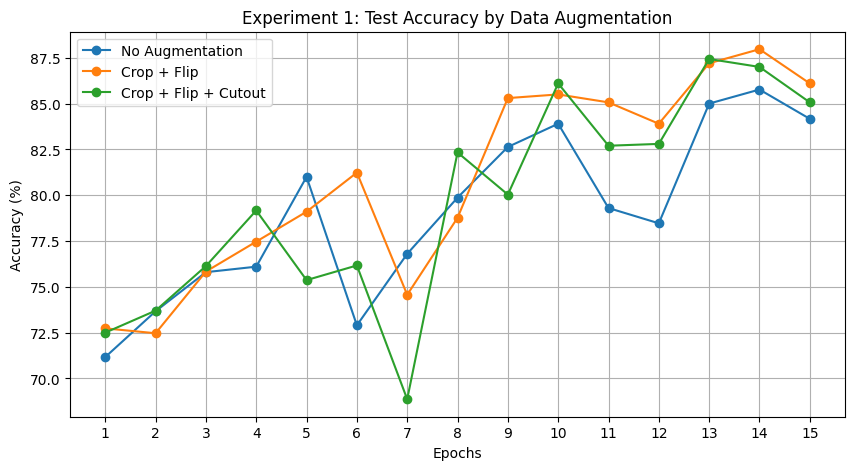

In [32]:
# 실험 1: 데이터 증강(Transform) 조합에 따른 성능 비교
print("\n========== Experiment 1: Data Augmentation Comparison ==========")

transforms_dict = {
    'No Augmentation': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]),
    'Crop + Flip': transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]),
    'Crop + Flip + Cutout': transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # RandomErasing은 텐서에 적용되므로 ToTensor 다음에 와야 합니다.
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
    ])
}
results_exp1 = {}
num_epochs_exp1 = 15
for name, transform in transforms_dict.items():
    print(f"[Experiment 1] Testing with: {name}"); set_seed(SEED)
    train_dataset = CustomDataset(reduced_train_pil, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

    model = ResNet(block_class=ResNet_block_NoGammaInit)
    model.load_state_dict(neutral_initial_weights)
    # 중립 가중치 로드 후, Gamma=0을 명시적으로 확정
    set_last_bn_gamma(model, 0.0)

    history = train_and_evaluate(model, train_loader, test_loader, num_epochs_exp1)
    results_exp1[name] = history

# 결과 시각화
plt.figure(figsize=(10, 5))
for name, history in results_exp1.items():
  plt.plot(range(1, num_epochs_exp1 + 1), history['accuracy'], marker='o', linestyle='-', label=name)

plt.title('Experiment 1: Test Accuracy by Data Augmentation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.xticks(range(1, num_epochs_exp1 + 1))

plt.show()

### 2. Identity Mapping (Gamma=0 초기화) 효과 비교

- Gamma 초기화 코드가 없는 새로운 모델 클래스 `ResNet_NoGammaInit`를 정의합니다.

- 기존 ResNet 모델(Gamma 초기화 적용)과 새로운 `ResNet_NoGammaInit` 모델을 동일한 데이터로 학습시킵니다.

- 두 모델의 학습 곡선(손실, 정확도)을 그래프로 그려 수렴 속도와 성능 차이를 시각적으로 비교합니다.

In [35]:
# 실험 2: Identity Mapping 효과 비교
print("\n========== Experiment 2: Identity Mapping Comparison ==========")

results_exp2 = {}; num_epochs_exp2 = 15
baseline_transform = transforms_dict['Crop + Flip']
set_seed(SEED)
train_dataset_exp2 = CustomDataset(reduced_train_pil, transform=baseline_transform)
train_loader_exp2 = torch.utils.data.DataLoader(train_dataset_exp2, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

model_with_gamma_init     = ResNet(block_class=ResNet_block_NoGammaInit)
model_without_gamma_init  = ResNet(block_class=ResNet_block_NoGammaInit)

model_with_gamma_init.load_state_dict(neutral_initial_weights)
model_without_gamma_init.load_state_dict(neutral_initial_weights)

set_last_bn_gamma(model_with_gamma_init, 0.0)      # 실험군 (Gamma=0)


========== Experiment 2: Identity Mapping Comparison ==========
[init] last BN gamma <- 0.0 (applied to 16 bottlenecks)


In [36]:
name, model = "Default", model_without_gamma_init
print(f"\n[Experiment 2] Testing model: {name}")
history = train_and_evaluate(model, train_loader_exp2, test_loader, num_epochs_exp2)
results_exp2[name] = history


[Experiment 2] Testing model: Default
--- Training Start ---
Epoch 1/15 - Loss: 1.3877, Acc: 69.93%, Time: 52.09s
Epoch 2/15 - Loss: 0.7380, Acc: 73.57%, Time: 51.22s
Epoch 3/15 - Loss: 0.6474, Acc: 79.87%, Time: 51.73s
Epoch 4/15 - Loss: 0.5423, Acc: 79.20%, Time: 51.39s
Epoch 5/15 - Loss: 0.4802, Acc: 81.40%, Time: 51.61s
Epoch 6/15 - Loss: 0.4418, Acc: 85.20%, Time: 51.57s
Epoch 7/15 - Loss: 0.4340, Acc: 80.90%, Time: 51.51s
Epoch 8/15 - Loss: 0.4185, Acc: 84.17%, Time: 51.42s
Epoch 9/15 - Loss: 0.3770, Acc: 88.13%, Time: 51.47s
Epoch 10/15 - Loss: 0.3441, Acc: 87.27%, Time: 51.49s
Epoch 11/15 - Loss: 0.3401, Acc: 87.23%, Time: 51.52s
Epoch 12/15 - Loss: 0.2909, Acc: 89.10%, Time: 51.43s
Epoch 13/15 - Loss: 0.2759, Acc: 85.53%, Time: 51.46s
Epoch 14/15 - Loss: 0.3468, Acc: 86.70%, Time: 51.45s
Epoch 15/15 - Loss: 0.2685, Acc: 90.33%, Time: 51.57s
--- Training Finished ---



In [38]:
name, model = "With Gamma=0 Init", model_with_gamma_init
print(f"\n[Experiment 2] Testing model: {name}")
history = train_and_evaluate(model, train_loader_exp2, test_loader, num_epochs_exp2)
results_exp2[name] = history


[Experiment 2] Testing model: With Gamma=0 Init
--- Training Start ---
Epoch 1/15 - Loss: 0.5377, Acc: 78.67%, Time: 51.78s
Epoch 2/15 - Loss: 0.4874, Acc: 82.57%, Time: 51.72s
Epoch 3/15 - Loss: 0.4614, Acc: 78.83%, Time: 51.56s
Epoch 4/15 - Loss: 0.4130, Acc: 86.00%, Time: 51.58s
Epoch 5/15 - Loss: 0.3812, Acc: 84.73%, Time: 51.50s
Epoch 6/15 - Loss: 0.3604, Acc: 87.77%, Time: 51.62s
Epoch 7/15 - Loss: 0.3304, Acc: 86.17%, Time: 51.65s
Epoch 8/15 - Loss: 0.3111, Acc: 85.53%, Time: 51.66s
Epoch 9/15 - Loss: 0.2996, Acc: 88.00%, Time: 51.56s
Epoch 10/15 - Loss: 0.2894, Acc: 88.63%, Time: 51.63s
Epoch 11/15 - Loss: 0.2810, Acc: 82.60%, Time: 51.43s
Epoch 12/15 - Loss: 0.2805, Acc: 89.83%, Time: 51.47s
Epoch 13/15 - Loss: 0.2478, Acc: 88.23%, Time: 51.57s
Epoch 14/15 - Loss: 0.2432, Acc: 91.40%, Time: 51.76s
Epoch 15/15 - Loss: 0.2332, Acc: 90.13%, Time: 51.72s
--- Training Finished ---



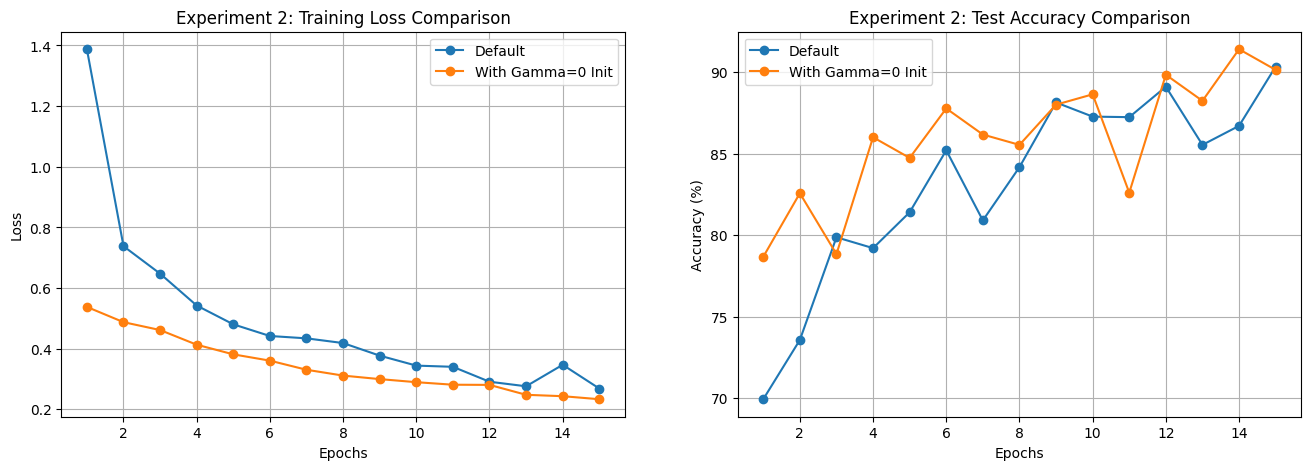

In [39]:
# 결과 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

for name, history in results_exp2.items():
  ax1.plot(range(1, num_epochs_exp2 + 1), history['loss'], marker='o', label=name)

ax1.set_title('Experiment 2: Training Loss Comparison')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

for name, history in results_exp2.items():
  ax2.plot(range(1, num_epochs_exp2 + 1), history['accuracy'], marker='o', label=name)

ax2.set_title('Experiment 2: Test Accuracy Comparison')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.show()